Use this link for get the weights
<br>"https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth"

In [13]:
# %load_ext autoreload
# %autoreload 2
import torch
import torchvision
import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    sys.path.remove(path)
import cv2
import os

from PIL import Image
import matplotlib.pyplot as plt
from models import EfficientDet
from torchvision import transforms
import numpy as np
import skimage
from datasets import get_augumentation, VOC_CLASSES
from timeit import default_timer as timer
import argparse
import copy
from utils import vis_bbox, EFFICIENTDET, get_state_dict

In [39]:
class args():
    weight = "checkpoint_VOC_efficientdet-d0_268.pth"#'/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/checkpoints/VOC/efficientdet-d0/bicubic_checkpoint_66.pth'#checkpoints/VOC/efficientdet-d0/checkpoint_299.pth'
    #"checkpoint_VOC_efficientdet-d0_268.pth" #'./checkpoint_VOC_efficientdet-d0_268.pth' 
    threshold = 0.5
    iou_threshold = 0.6
    score = True
    file_name = None#'demo.png'
    
    num_class = 20
    cam = False

In [40]:
class Detect(object):
    """
        dir_name: Folder or image_file
    """

    def __init__(self, weights, num_class=21, network='efficientdet-d0', size_image=(512,512)): #(512,512)
        super(Detect,  self).__init__()
        self.weights = weights
        self.size_image = size_image
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else 'cpu')
        self.transform = get_augumentation(phase='test')
        if(self.weights is not None):
            print('Load pretrained Model')
            checkpoint = torch.load(
                self.weights, map_location=lambda storage, loc: storage)
            params = checkpoint['parser']
            num_class = params.num_class
            network = 'efficientdet-d0'#params.network

        self.model = EfficientDet(num_classes=num_class,
                                  network=network,
                                  W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                                  D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                                  D_class=EFFICIENTDET[network]['D_class'],
                                  is_training=False
                                  )

        if(self.weights is not None):
            state_dict = checkpoint['state_dict']
            self.model.load_state_dict(state_dict, strict=False)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.model.eval()

    def process(self, threshold, iou_threshold, file_name=None, img=None, show=False):
        if file_name is not None:
            img = cv2.imread(file_name)
        origin_img = copy.deepcopy(img)
        augmentation = self.transform(image=img)
        img = augmentation['image']
        img = img.to(self.device)
        img = img.unsqueeze(0)

        with torch.no_grad():
            scores, classification, transformed_anchors = self.model(img)
            
            # filter by score
            transformed_anchors = transformed_anchors[scores > threshold]
            scores = scores[scores > threshold]
            classification = scores[[scores > threshold]]

            # NMS
            keep_nms = torchvision.ops.nms(transformed_anchors, scores, iou_threshold)
            transformed_anchors = transformed_anchors[keep_nms]
            
            bboxes = list()
            labels = list()
            bbox_scores = list()
            colors = list()
            for j in range(transformed_anchors.shape[0]):
                bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
                x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
                y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
                x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
                y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
                bboxes.append([x1, y1, x2, y2])
                label_name = VOC_CLASSES[int(classification[[j]])]
                labels.append(label_name)

                if(args.cam):
                    cv2.rectangle(origin_img, (x1, y1),
                                  (x2, y2), (179, 255, 179), 2, 1)
                if args.score:
                    score = np.around(
                        scores[[j]].cpu().numpy(), decimals=2) * 100
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{} {}'.format(
                            label_name, int(score)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (223, 128, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
                    bbox_scores.append(int(score))
                else:
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{}'.format(
                            label_name), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (0, 102, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
            if show:
                origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
                fig, ax = vis_bbox(img=origin_img, bbox=bboxes,
                                   label=labels, score=bbox_scores)
                fig.savefig('./docs/demo.png')
                plt.show()
            else:
                return origin_img

    def camera(self):
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Unable to open camera")
            exit(-1)
        count_tfps = 1
        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
        while True:
            res, img = cap.read()
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1

            if accum_time > 1:
                accum_time = accum_time - 1
                fps = curr_fps
                curr_fps = 0
            if res:
                show_image = self.process(img=img)
                cv2.putText(
                    show_image, "FPS: " + str(fps), (10,  20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (204, 51, 51), 2
                )

                cv2.imshow("Detection", show_image)
                k = cv2.waitKey(1)
                if k == 27:
                    break
            else:
                print("Unable to read image")
                exit(-1)
            count_tfps += 1
        cap.release()
        cv2.destroyAllWindows()

Load pretrained Model
Loaded pretrained weights for efficientnet-b0


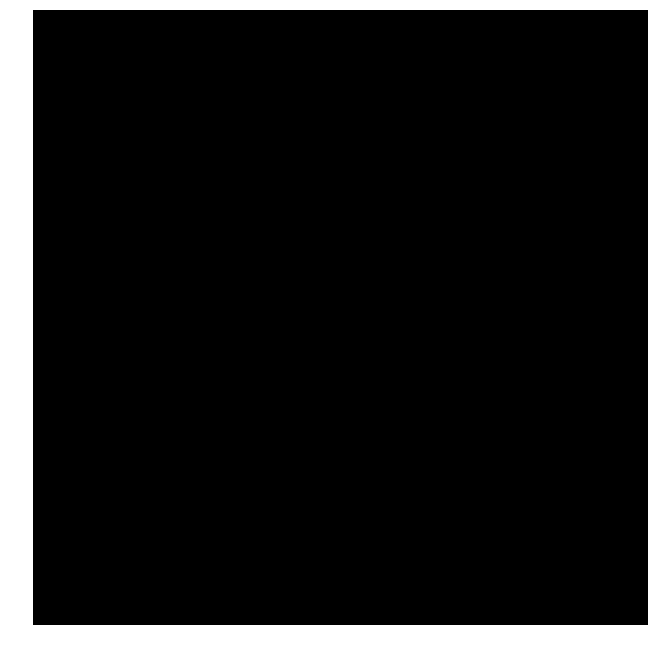

In [41]:
detect = Detect(weights=args.weight)

detect.process(args.threshold, args.iou_threshold, file_name=args.file_name, img=args.img, show=True)

In [20]:
# mod_inputs = torch.load('inp.pt')

import matplotlib.pyplot as plt
def show_tensor(ori):
    img = ori.squeeze().cpu().permute(1,2,0).detach().numpy()
    img -= np.min(img)
    img /= np.max(img)
    plt.figure(figsize=(10,10))
    plt.imshow(img[:,:,(0,1,2)])
    

## For training

In [21]:
import train
import models
import importlib
importlib.reload(train)
from datasets import VOCDetection, CocoDataset, get_augumentation, detection_collate, Resizer, Normalizer, Augmenter, collater
from torch.utils.data import DataLoader
from torch import optim

In [22]:
train_dataset.__getitem__(2)['img'].float().shape

torch.Size([512, 512, 3])

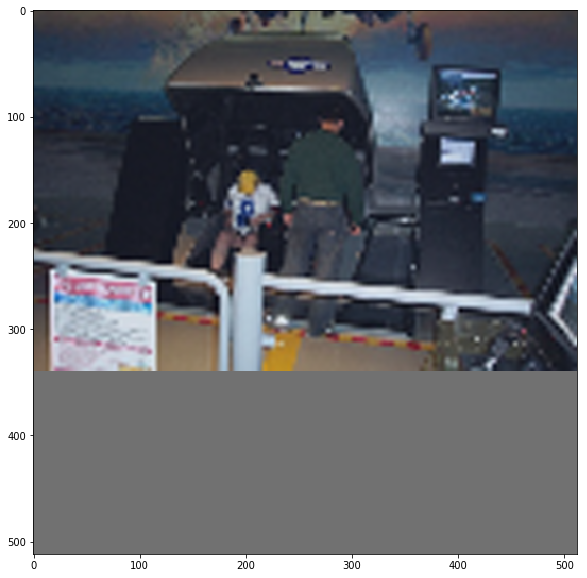

In [27]:
show_tensor(valid_dataset.__getitem__(10)['img'].permute((2,0,1)).float())

In [10]:
class args():
#     weight = './checkpoint_VOC_efficientdet-d0_268.pth'
    threshold = 0.5
    iou_threshold = 0.6
    score = True
    file_name = 'demo.png'
    num_class = 20
    cam = False
    resume = '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/checkpoints/VOC/efficientdet-d0/bicubic_checkpoint_24.pth' #path for torch.load
    #'./checkpoint_VOC_efficientdet-d0_268.pth'
    
    lr = 1e-4
    batch_size = 16
    workers = 1
    network = 'efficientdet-d0'
    start_epoch = 0
    num_epoch = 100
    dataset = 'VOC'
    grad_accumulation_steps = 1
    save_folder = 'checkpoints'

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root = "/media/sf/61CEC7C06EDB83CC/VOCdevkit" #'/home/sf/VOCdevkit/'
# load VOC 2007
train_dataset = VOCDetection(root="/media/sf/61CEC7C06EDB83CC/VOCdevkit", image_sets=[('2007', 'train')],transform=transforms.Compose(
    [Normalizer(), Augmenter(), Resizer()]))
valid_dataset = VOCDetection(root="/media/sf/61CEC7C06EDB83CC/VOCdevkit", image_sets=[(
    '2007', 'val')], transform=transforms.Compose([Normalizer(), Resizer()]))
args.num_classes = train_dataset.num_classes()

train_loader = DataLoader(train_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.workers,
                          shuffle=True,
                          collate_fn=collater,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=1,
                          num_workers=args.workers,
                          shuffle=False,
                          collate_fn=collater,
                          pin_memory=True)

In [12]:
importlib.reload(models)
importlib.reload(train)

# Load existing checkpoint if args.resume = true
checkpoint = []
if(args.resume is not None):
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume, map_location=device)
    params = checkpoint['parser']
    args.num_class = params.num_class
    args.network = params.network
    args.start_epoch = checkpoint['epoch'] + 1
    del params

model = models.EfficientDet(num_classes=args.num_class, network=args.network,
                     W_bifpn=EFFICIENTDET[args.network]['W_bifpn'],
                     D_bifpn=EFFICIENTDET[args.network]['D_bifpn'],
                     D_class=EFFICIENTDET[args.network]['D_class'])

if(args.resume is not None):
    model.load_state_dict(checkpoint['state_dict'], strict=False)
del checkpoint

=> loading checkpoint '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/checkpoints/VOC/efficientdet-d0/bicubic_checkpoint_24.pth'
Loaded pretrained weights for efficientnet-b0


In [12]:
## freeze all layers except for the convs
# for name, param in model.named_parameters():
#     if name[:4] != 'conv':
#         param.requires_grad = False

# for name, param in model.named_parameters():
#     if name[:4] == 'conv':
#         print(param.requires_grad)

In [33]:
model = model.to(device)

In [34]:
# for training
importlib.reload(train)
import os
# define loss function (criterion) , optimizer, scheduler
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, verbose=True)
#cudnn.benchmark = True

for epoch in range(args.start_epoch, args.num_epoch):
    train.train(train_loader, model, scheduler, optimizer, epoch, args)

    if (epoch + 1) % 5 == 0:
        train.test(valid_dataset, model, epoch, args)

    state = {
        'epoch': epoch,
        'parser': args,
        'state_dict': get_state_dict(model)
    }

    torch.save(
        state,
        os.path.join(
            args.save_folder,
            args.dataset,
            args.network,
            "bicubic_checkpoint_{}.pth".format(epoch)))

hi from train.py
25 epoch: 	 start training....
100 iteration: training ...
    epoch          : 25
    mean_loss      : 3230.0641673207283
    cls_loss       : 20.171409606933594
    reg_loss       : 2.373972177505493
    iteration      : 100
    time           : 157.99588084220886
    loss           : 2077.0669388679944
hi from train.py
26 epoch: 	 start training....
200 iteration: training ...
    epoch          : 26
    mean_loss      : 614.0565132595772
    cls_loss       : 3.6845767498016357
    reg_loss       : 1621.8448486328125
    iteration      : 200
300 iteration: training ...
    epoch          : 26
    mean_loss      : 343.8081259744151
    cls_loss       : 4.3162078857421875
    reg_loss       : 1.0313591957092285
    iteration      : 300
    time           : 161.61676692962646
    loss           : 313.6327258113084
hi from train.py
27 epoch: 	 start training....
400 iteration: training ...
    epoch          : 27
    mean_loss      : 10981.0893513491
    cls_loss       

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [14]:
#for testing model only
train.test(valid_dataset, model, 0, args)

0 epoch: 	 start validation....
2510/2510
mAP:
aeroplane: 0.0
bicycle: 0.0
bird: 0.0
boat: 0.0
bottle: 0.0
bus: 0.0
car: 0.0
cat: 0.0
chair: 0.0
cow: 0.0
diningtable: 0.0
dog: 0.0
horse: 0.0
motorbike: 0.0
person: 0.0
pottedplant: 0.0
sheep: 0.0
sofa: 0.0
train: 0.0
tvmonitor: 0.0
avg mAP: 0.0


In [1]:
import torch

In [ ]:
torch.cuda.current_device()
# torch.cuda.is_available()
# torch.cuda.get_device_name(0)

---

### Visualizing conv outputs

In [19]:
pic = next(iter(train_loader))[0]

In [20]:
def show_tensor(pic):
    return torchvision.transforms.ToPILImage()(((pic - pic.min())/(pic.max() - pic.min())).float())

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv1.weight.data.normal_(1/27,1e-2)
        self.conv1.bias.data.normal_(0,1e-5)
#         print(self.conv1.weight)
        
        self.conv2 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv2.weight.data.normal_(1/27,1e-2)
        self.conv2.bias.data.normal_(0,1e-5)
        self.conv3 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv3.weight.data.normal_(1/27,1e-2)
        self.conv3.bias.data.normal_(0,1e-5)
        
    def forward(self, x):
        inp = x
        x = torch.sigmoid(self.conv1(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x1.pt')
        x = torch.sigmoid(self.conv2(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x2.pt')
        x = torch.sigmoid(self.conv3(x)) + 0.02*inp
        #torch.save(modified_inputs, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/inp.pt')
        return x

## tranposed layers

In [117]:
class Model(nn.Module):
    def __init__(self):
        sf = 9
        super(Model, self).__init__()
        self.conv1 = torch.nn.ConvTranspose2d(3,3,3, padding=1, stride=2)
        self.conv1.weight.data.normal_(1/sf,1e-2)
        self.conv1.bias.data.normal_(0,1e-5)
#         print(self.conv1.weight)
        
        self.conv2 = torch.nn.ConvTranspose2d(3,3,4, padding=0, stride=2)
        self.conv2.weight.data.normal_(1/sf,1e-2)
        self.conv2.bias.data.normal_(0,1e-5)
        self.conv3 = torch.nn.ConvTranspose2d(3,3,3, padding=1)
        self.conv3.weight.data.normal_(1/sf,1e-2)
        self.conv3.bias.data.normal_(0,1e-5)
        
    def forward(self, x):
        inp = x
        x = torch.sigmoid(self.conv1(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x1.pt')
        x = torch.sigmoid(self.conv2(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x2.pt')
        inp_up = torch.nn.Upsample(scale_factor=4, mode='bilinear')(inp)
        
        x = torch.sigmoid(self.conv3(x)) + 1*inp_up
        #torch.save(modified_inputs, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/inp.pt')
        return x



## subpixel conv

In [151]:
class Model(nn.Module):
    def __init__(self):
        sf = 9
        super(Model, self).__init__()
        #first layer of conv
        self.conv1 = torch.nn.Conv2d(3,64,3, padding=1, stride=1)
        self.conv1.weight.data.normal_(1/sf,1e-2)
        self.conv1.bias.data.normal_(0,1e-5)
        
        #res block
        self.conv2 = torch.nn.Conv2d(64,64,3, padding=1, stride=1)
        self.conv2.weight.data.normal_(1/sf,1e-2)
        self.conv2.bias.data.normal_(0,1e-5)
        #add batch norm
        
        self.conv3 = torch.nn.Conv2d(64,64,3, padding=1, stride=1)
        self.conv3.weight.data.normal_(1/sf,1e-2)
        self.conv3.bias.data.normal_(0,1e-5)
        #add batchnorm
        
        # finishing conv 
        
        self.conv4 = torch.nn.Conv2d(3,48,3, padding=1, stride=1)
        self.conv4.weight.data.normal_(1/sf,1e-2)
        self.conv4.bias.data.normal_(0,1e-5)
        
#         print(self.conv1.weight)
        
#         self.conv2 = torch.nn.Conv2d(12,24,3, padding=1, stride=2)
#         self.conv2.weight.data.normal_(1/sf,1e-2)
#         self.conv2.bias.data.normal_(0,1e-5)
    
#         self.conv2 = torch.nn.ConvTranspose2d(3,3,4, padding=0, stride=2)
#         self.conv2.weight.data.normal_(1/sf,1e-2)
#         self.conv2.bias.data.normal_(0,1e-5)
#         self.conv3 = torch.nn.ConvTranspose2d(3,3,3, padding=1)
#         self.conv3.weight.data.normal_(1/sf,1e-2)
#         self.conv3.bias.data.normal_(0,1e-5)
        
    def forward(self, x):
        inp = x
        x = self.conv1(x)
        inp_up = torch.nn.Upsample(scale_factor=4, mode='bilinear')(inp)
        
        x = torch.nn.functional.pixel_shuffle(x, 4)
        print(x.shape)
        x+=inp_up
        
        
        #torch.save(modified_inputs, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/inp.pt')
        return x



In [152]:
model = Model()

torch.Size([1, 3, 2048, 2048])


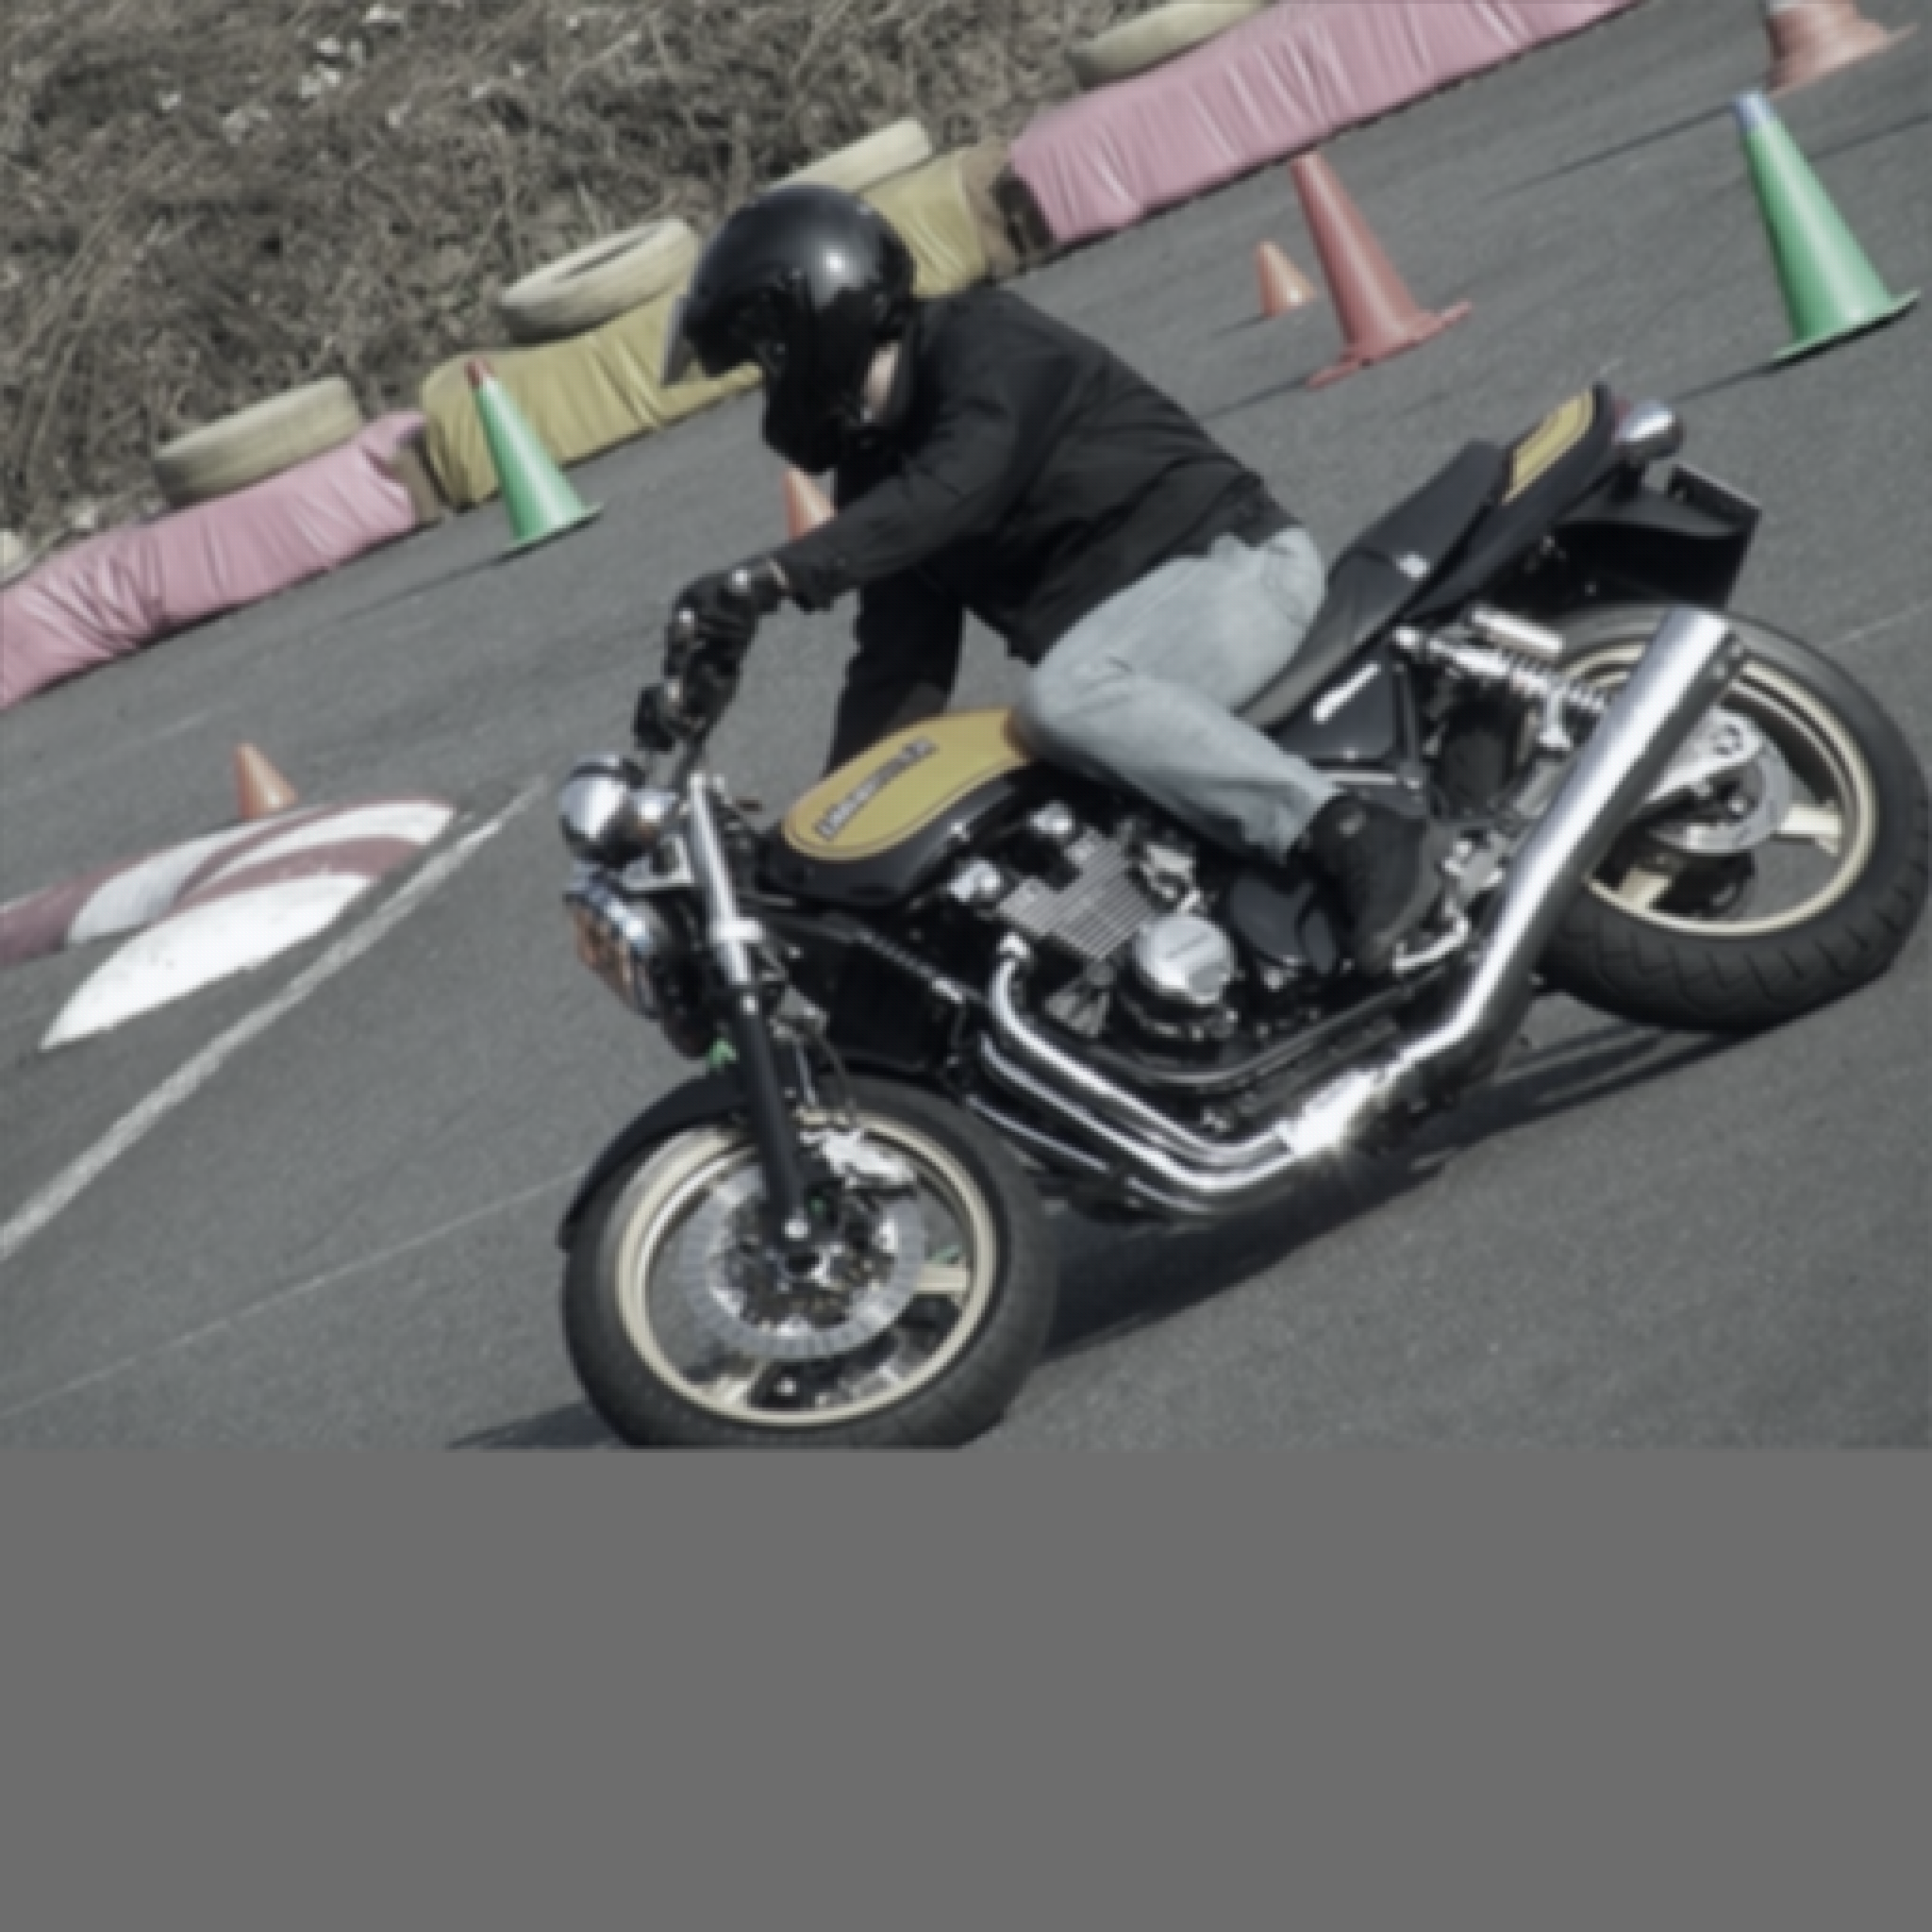

In [153]:
show_tensor(model(pic[1].unsqueeze(0).float()).squeeze())

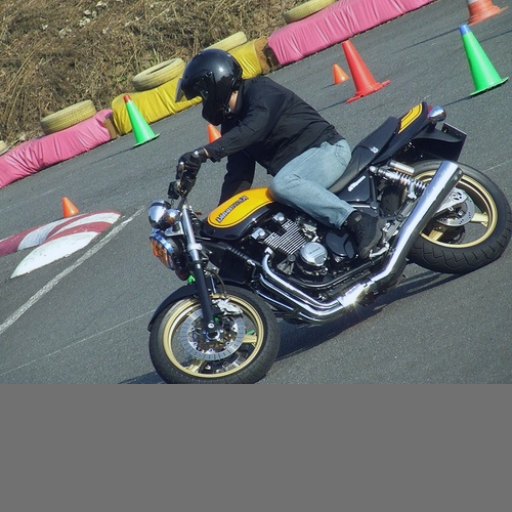

In [120]:
show_tensor(pic[1])

In [116]:
model(pic[1].unsqueeze(0).float()).squeeze().size()

torch.Size([3, 2048, 2048])